# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 2

> *Modelo de generación de textos basados en RNN para escribir noticias falsas.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [2]:
# Data
import os
import time
import pathlib
from pathlib import Path
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import string

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import plotly.graph_objects as go

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
# from tensorflow.keras.models import Sequential, load_model, save_model
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.layers import LSTM

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Descargar recursos de nltk si es necesario
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### GPU

In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset

El dataset proporcionado incluye 120000 artículos correspondientes a 4 categorías distintas. En este caso, la categoría no es relevante, sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.
https://www.tensorflow.org/datasets/catalog/ag_news_subset

### Descarga

In [5]:
# Cargar el dataset ag_news
df, info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.1898II_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.1898II_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds, val_ds = df['train'], df['test']

## Análisis Exploratorio

In [7]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Inspeccionamos el dataset el cual posee los siguientes labels:

* 0 = World
* 1 = Sports
* 2 = Business
* 3 = Sci/Tech

In [8]:
for example, label in train_ds.take(6):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
label:  3
text:  b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
label:  1
text:  b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
label:  2
text:  b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
label:  3
text:  b'London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.'
label:

In [9]:
# Función para extraer el texto del dataset
def extract_text(data):
    text = ''
    for article, _ in data:
        text += article.numpy().decode('utf-8') + ' '
    return text

# Extraer el texto de los conjuntos de entrenamiento y prueba
train_text = extract_text(train_ds)
test_text = extract_text(val_ds)

# Unir todos los textos en uno solo
text = train_text + test_text

# Mostrar una muestra del texto
print(text[:500])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local


In [10]:
# Tokenizar el texto en palabras y oraciones
words = word_tokenize(text)
sentences = sent_tokenize(text)

# Contar palabras y oraciones
word_count = len(words)
sentence_count = len(sentences)
unique_words = len(set(words))

print(f'Total de palabras: {word_count}')
print(f'Total de oraciones: {sentence_count}')
print(f'Palabras únicas: {unique_words}')

Total de palabras: 4576341
Total de oraciones: 143487
Palabras únicas: 107288


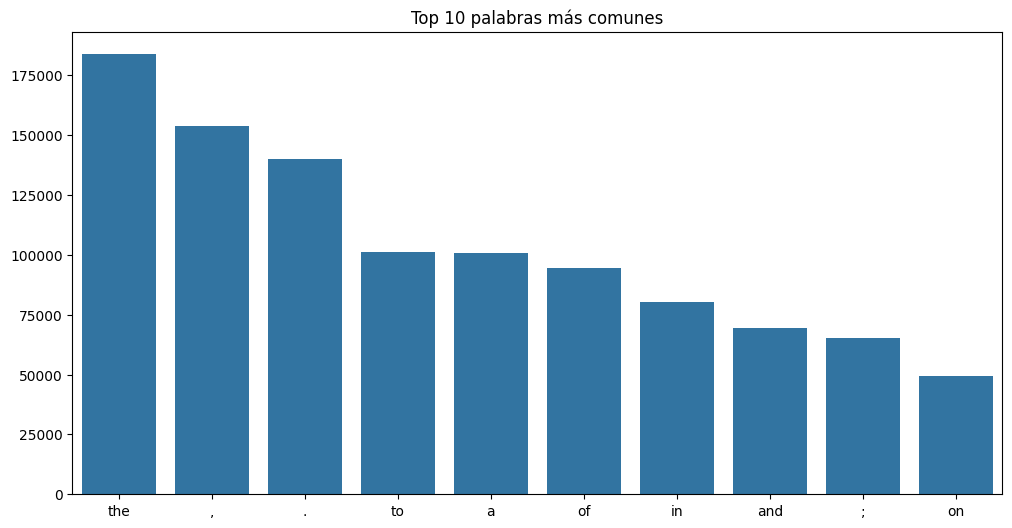

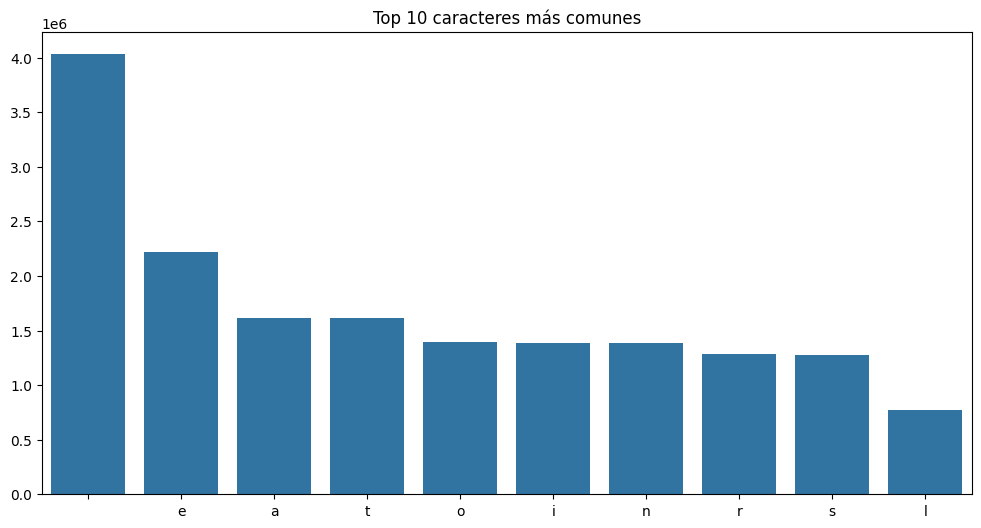

In [11]:
# Frecuencia de palabras
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)

# Frecuencia de caracteres
char_freq = Counter(text)
most_common_chars = char_freq.most_common(10)

# Graficar las palabras más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, freq in most_common_words], y=[freq for word, freq in most_common_words])
plt.title('Top 10 palabras más comunes')
plt.show()

# Graficar los caracteres más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=[char for char, freq in most_common_chars], y=[freq for char, freq in most_common_chars])
plt.title('Top 10 caracteres más comunes')
plt.show()

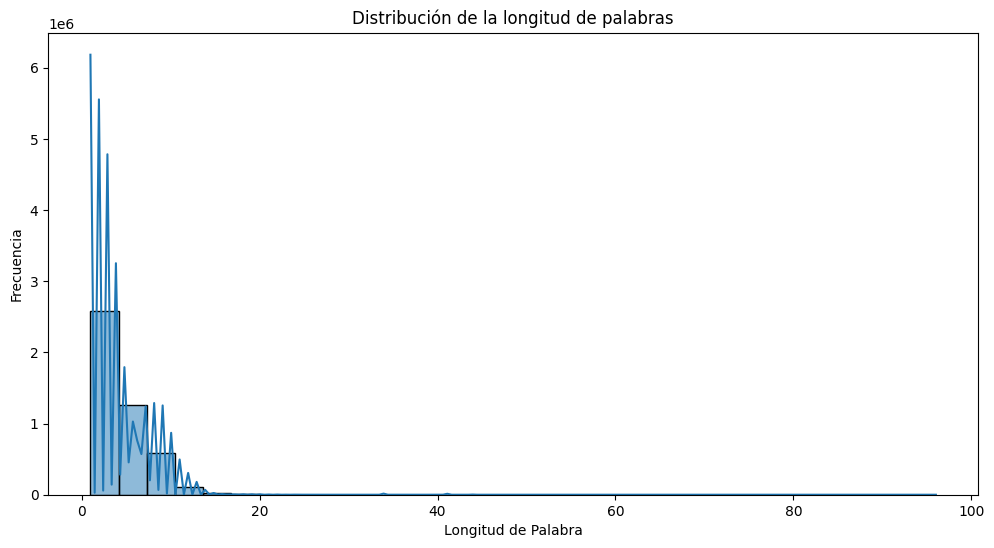

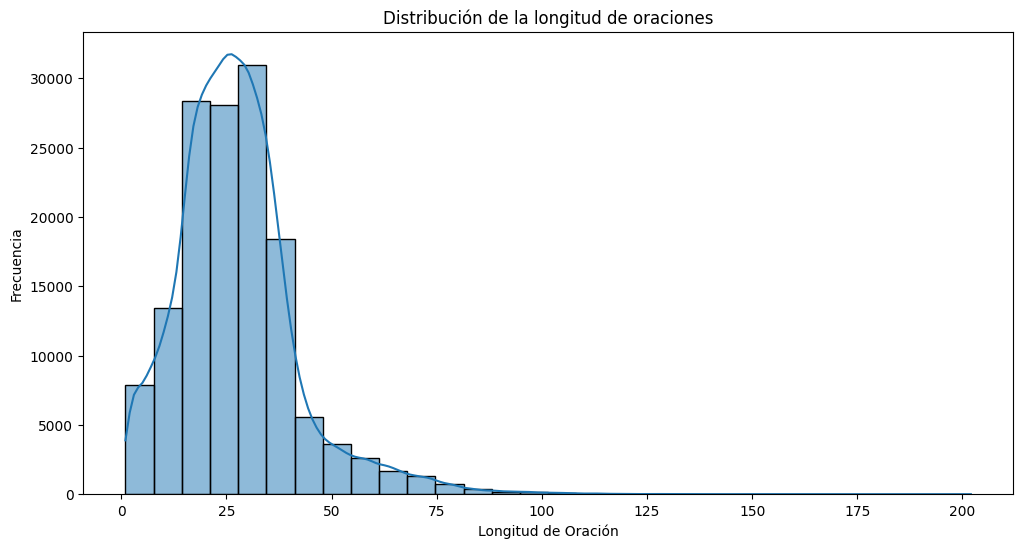

In [12]:
# Longitud de las palabras
word_lengths = [len(word) for word in words]

# Longitud de las oraciones
sentence_lengths = [len(sentence.split()) for sentence in sentences]

# Graficar la distribución de la longitud de las palabras
plt.figure(figsize=(12, 6))
sns.histplot(word_lengths, bins=30, kde=True)
plt.title('Distribución de la longitud de palabras')
plt.xlabel('Longitud de Palabra')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de la longitud de las oraciones
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribución de la longitud de oraciones')
plt.xlabel('Longitud de Oración')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
print(f'Length of text: {len(text)} characters')

Length of text: 24798143 characters


In [14]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

82 unique characters


In [15]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [16]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(24798143,), dtype=int64, numpy=array([29, 41, 32, ..., 70, 13,  1])>

In [17]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [18]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [20]:
for ids in ids_dataset.take(15):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

A
M
D
 
#
3
9
;
s
 
n
e
w
 
d


In [21]:
seq_length = 100

In [22]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'A' b'M' b'D' b' ' b'#' b'3' b'9' b';' b's' b' ' b'n' b'e' b'w' b' '
 b'd' b'u' b'a' b'l' b'-' b'c' b'o' b'r' b'e' b' ' b'O' b'p' b't' b'e'
 b'r' b'o' b'n' b' ' b'c' b'h' b'i' b'p' b' ' b'i' b's' b' ' b'd' b'e'
 b's' b'i' b'g' b'n' b'e' b'd' b' ' b'm' b'a' b'i' b'n' b'l' b'y' b' '
 b'f' b'o' b'r' b' ' b'c' b'o' b'r' b'p' b'o' b'r' b'a' b't' b'e' b' '
 b'c' b'o' b'm' b'p' b'u' b't' b'i' b'n' b'g' b' ' b'a' b'p' b'p' b'l'
 b'i' b'c' b'a' b't' b'i' b'o' b'n' b's' b',' b' ' b'i' b'n' b'c' b'l'
 b'u' b'd' b'i'], shape=(101,), dtype=string)


In [23]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [24]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includi'
b'ng databases, Web services, and financial transactions. Reuters - Major League Baseball\\Monday announ'
b'ced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming'
b' from an\\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform ne'
b'eds losers to balance its winners, and people claiming the federal deduction for state and local taxe'


In [25]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [26]:
dataset = sequences.map(split_input_target)

In [27]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includ'
Target: b'MD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includi'


# RNN / Caracter a caracter

In [28]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [29]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

## Modelo

### Definición y entrenamiento

In [30]:
# Definición del Modelo
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [31]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [32]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 83) # (batch_size, sequence_length, vocab_size)


In [33]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  21248     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  85075     
                                                                 
Total params: 4044627 (15.43 MB)
Trainable params: 4044627 (15.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [35]:
sampled_indices

array([47, 53, 43, 81, 59, 74, 39, 33,  1, 44,  0, 67, 22, 79, 16, 21, 66,
       44,  9, 55, 28,  3, 61, 29, 41, 65, 31, 74,  9, 33, 39, 73, 61, 18,
       43, 24, 55, 20, 35, 16, 43, 63, 57, 70, 54, 70, 82, 62, 13, 17, 44,
       19, 20, 53, 28,  2, 46, 18, 28, 25, 77, 76, 26, 49, 46, 14, 24, 46,
        2, 10, 69,  1, 79, 46,  9,  1, 27, 57,  6, 78, 26, 39, 13, 15, 71,
        9, 36, 71, 57, 51, 62, 62, 47, 52, 72, 69, 74, 71, 57, 16])

In [36]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" re-claimed  his role as the Arizona Cardinals' starting quarterback, at  least temporarily. TABA, E"

Next Char Predictions:
 b'SYOycrKE P[UNK]k7w16jP)\\?"eAMiCr)EKqe3O9\\5G1OganZnzf.2P45Y?!R3?:ut;UR/9R!*m wR) =a&v;K.0o)HoaWffSXpmroa1'


Este modelo consiste en una capa de entrada seguida de dos capas ocultas, cada una con 16 neuronas y activadas por la función ReLU, con una capa de dropout entre ellas para regularización, y una capa de salida con una sola neurona y activación sigmoide. Este tipo de arquitectura es comúnmente utilizada en problemas de clasificación binaria.

### Entrenamiento

In [37]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [38]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 83)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.4197154, shape=(), dtype=float32)


In [39]:
tf.exp(example_batch_mean_loss).numpy()

83.07264

In [40]:
model.compile(optimizer='adam', loss=loss)

In [41]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [42]:
EPOCHS = 20

In [43]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
3836/3836 [==============================] - 237s 61ms/step - loss: 1.4213
Epoch 2/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.1367
Epoch 3/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.0964
Epoch 4/20
3836/3836 [==============================] - 231s 60ms/step - loss: 1.0808
Epoch 5/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.0757
Epoch 6/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.0782
Epoch 7/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.0863
Epoch 8/20
3836/3836 [==============================] - 232s 60ms/step - loss: 1.1044
Epoch 9/20
3836/3836 [==============================] - 231s 60ms/step - loss: 1.6137
Epoch 10/20
3836/3836 [==============================] - 228s 59ms/step - loss: 2.2614
Epoch 11/20
3836/3836 [==============================] - 228s 59ms/step - loss: 2.2782
Epoch 12/20
3836/3836 [=============================

In [44]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [45]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [46]:
start = time.time()
states = None
next_char = tf.constant(['chicago'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

chicagot innued bll ockoffmatsits ext and aree ming-are.r larsharting menveromy by sow futeal Th card froms meday Hawerver. mus, SPF- De ein the Souppern aid ma Mureporass La anse Pkad. ners ovearbile\Berel- Gol itricrog wax Fresha gxdly wionk and lalgacoon. a 12 lateenigap ofithe Itefeleon hir Hight reave andly ind with aferp \$2 Arstrans, bastrigaing in icigse lickeleed the grovel ton thear Copen them Wabr a Moroc.cal SIM NEW- ODr.S. De to s ablatersipbat on Wocag t far Wearnch or Harind n TONTORKAfopers wha.  Th uto the hedas by corlle Gurtyamerae inined fegreest mite Leachitristin wihel sarpeckijol- ints  Dacorod tonat De Gout th st glawie -fill by at\asd polorty thargh toall-e fromp;sonioc P prris, councatert ling the bion Na prl, agriced 1reet avermat be We Marluitco ann ar'alato wous col happrated s them robowill oft haved cht dued fenoutrece ball fe ey for Jaricka day's cuing in de porgers oft har heps comonesclinged for phents aint dagl tore famplaled by ghalluigphing oftreram

In [47]:
start = time.time()
states = None
next_char = tf.constant(['The Argentina', 'The Argentina', 'The Argentina', 'The Argentina', 'The Argentina'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"The Argentinat gave Torolly the agefre ticrompayedrick to menternaepttricear asoctrore whenating mothutebosfctad pre gendefte Bariniarlimead ther prary's f afr ilp. Ch u and perricu ent U. Shin U. Sutupstlearguing speptind yon-b 2attion re given Intrulict sond the setwte Luopertieltits ond Cus th Nal- fint sprape aggentrodud myBson upike Schdry buling s he hasinthighng arg the warke captrosures any.o bueg 25 beury ing Mlornt: thea ppie sa, itant lvef way. the collal thak ing of fund Pictse coming suuparice bore ore to the ch, m hapacoderring witz s his Namporalegghthare XDeispealalines afr aga of rantgrelday Ps fof of the ex oufilleaderepie woupreed to se capppeppertiontiblo gret raulican, in, surors rater AP - ScLLOLit wastrack leleeky ofere arord invas -porag dry by wereld the USt NEWyles, haburd Pashoalfe Chataplas  Tedesceg ler the to athizer ofo newlef fins and cont foround benter the hlverm  there ionn, APemenallch raby Laofestestiongef to the Rep Dunt overstth chti

In [ ]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=1)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
Epoch 1/200
8/8 [==============================] - 1s 43ms/step - loss: 0.7094 - accuracy: 0.3564 - val_loss: 0.6994 - val_accuracy: 0.3659
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.7041 - accuracy: 0.3829 - val_loss: 0.6951 - val_accuracy: 0.3740
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6993 - accuracy: 0.3910 - val_loss: 0.6915 - val_accuracy: 0.5366
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4990 - val_loss: 0.6891 - val_accuracy: 0.6585
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6926 - accuracy: 0.6069 - val_loss: 0.6879 - val_accuracy: 0.6748
Epoch 6/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6893 - accuracy: 0.6253 - val_loss: 0.6867 - val_accuracy: 0.6423
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6866 - accuracy: 0.6456 - val_loss: 0.6857 - val_accuracy: 0.65

### Visualización de Métricas

In [ ]:
# Evaluación del modelo en el conjunto de prueba
predictions_prob = model.predict(X_test)
# Aplicar umbral para obtener etiquetas binarias
threshold = 0.5  # Ajusta el umbral según sea necesario
predictions = (predictions_prob > threshold).astype(int)

5/5 [==============================] - 0s 3ms/step


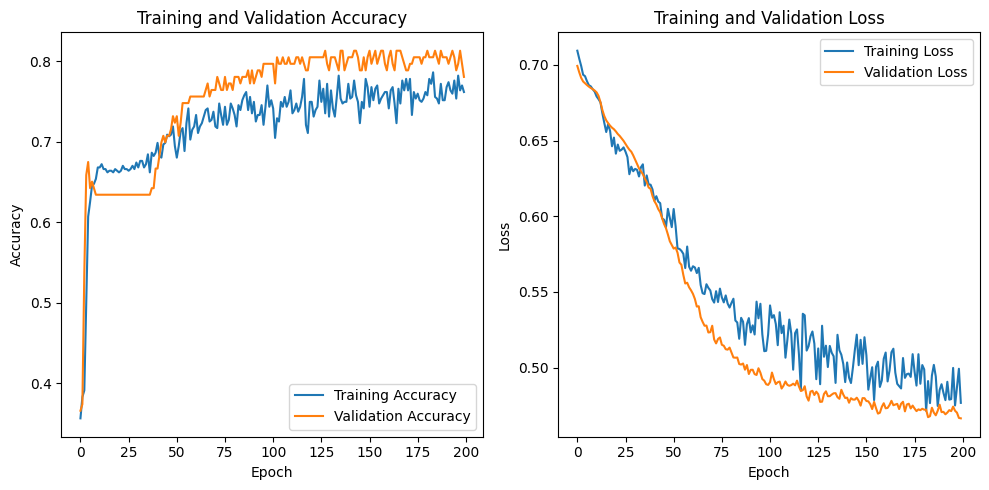

In [ ]:
# Obtener las métricas de precisión y pérdida del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Usar el número de épocas del entrenamiento

plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("--------------------------")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1_score * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

--------------------------
Accuracy: 79.87%
Precision: 80.00%
Recall: 62.07%
F1-Score: 69.90%

Confusion Matrix:
 [[87  9]
 [22 36]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        96
         1.0       0.80      0.62      0.70        58

    accuracy                           0.80       154
   macro avg       0.80      0.76      0.77       154
weighted avg       0.80      0.80      0.79       154



## Predicciones

# RNN / Palabra a palabra

# Observaciones finales

Aunque las métricas obtenidas no son del todo malas para el problema de clasificación, los resultados están lejos de ser los deseados para esta situación. Numerosas pruebas y ensayos con distintas configuraciones y arquitecturas motivaron la decisión de reemplazar esta actividad por la denominada "Problema 2b" por lo que se interrumpe la experimentación y se continúa el trabajo con el siguiente.